In [419]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns


In [420]:
!pip install python-dotenv


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Data Exploration

In [421]:
def load_data():
    load_dotenv()

    url = os.getenv("GOOGLE_SHEET_URL")
    df = pd.read_csv(url)
    return df



In [422]:
df = load_data()

df.head()

,Scam,Message
0,1,"Hey guys, I'm looking to sell my full season ..."
1,1,@everyone Just upgraded! Giving away my old Ca...
2,0,Hi everyone!!! So sorry for late notice but to...
3,1,"Hey guys, I’m looking to sell my full season t..."
4,0,god bless the admin


In [423]:
df['Scam'].value_counts()

Scam
1    97
0    96
Name: count, dtype: int64

In [424]:
df.shape

(193, 2)

In [425]:
group_df = df.groupby('Scam')['Message']

In [426]:
group_df.first()

Scam
0    Hi everyone!!! So sorry for late notice but to...
1    Hey guys, I'm looking to sell  my full season ...
Name: Message, dtype: object

In [427]:
df.isna().sum()

Scam       0
Message    0
dtype: int64

In [428]:
df = df.drop_duplicates()

In [429]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix


# Machine Learning and Feature Engineering

In [430]:
 # Additional features for training data
def extract_features(messages):
    features = pd.DataFrame()
    # Length of message
    features['length'] = messages.apply(len)
    # Count of digits
    features['digit_count'] = messages.apply(lambda x: sum(c.isdigit() for c in x))
    # Count of special characters
    features['special_char_count'] = messages.apply(lambda x: sum(c in "!@#$%^&*()-+=<>?/|\\" for c in x))
    # Count of uppercase words (often used in spam)
    features['uppercase_count'] = messages.apply(lambda x: sum(w.isupper() for w in x.split() if len(w) > 1))
    # Count of spam indicators
    spam_indicators = ["free", "win","winner", "won", "prize", "cash", "call", "text", "urgent", "claim", "click", "offer", "limited"]
    features['spam_indicator_count'] = messages.apply(lambda x: sum(w.lower() in spam_indicators for w in x.split()))
    # Presence of phone numbers (crude check)
    features['has_phone'] = messages.apply(lambda x: 1 if sum(c.isdigit() for c in x) > 8 else 0)
    # Money symbols
    features['has_money_symbol'] = messages.apply(lambda x: 1 if any(c in x for c in "£$€") else 0)

    return features

In [431]:
X = df['Message']
y = df['Scam']

In [432]:


X_train, X_test, y_train, y_test1 = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [433]:
def predict_message(vectorizer, X_train, X_test, y_train, y_test):

    # Fit vectorizer
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Train logistic regression
    model = LogisticRegression(class_weight="balanced")
    model.fit(X_train_vec, y_train)

    # Predictions
    y_pred = model.predict(X_test_vec)
    y_probs = model.predict_proba(X_test_vec)[:, 1]
    
    return model, y_pred, y_probs

   

    

In [434]:
def model_evaluation(y_test, y_pred):
     # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")

    cm = confusion_matrix(y_test, y_pred)


    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Not Spam (0)', 'Spam (1)'],
            yticklabels=['Not Spam (0)', 'Spam (1)'])

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


In [435]:
vectorizer= TfidfVectorizer(stop_words='english')

In [436]:
# make predictions
lr_base, pred_baselr, prob_baselr = predict_message(vectorizer, X_train, X_test, y_train, y_test1)


Accuracy:  0.8718
Precision: 0.7857
Recall:    0.8462


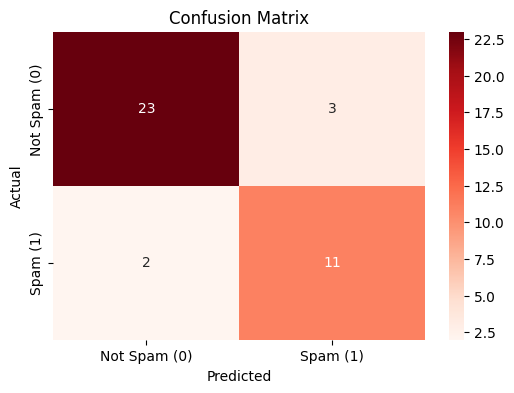

In [437]:
# evaluation model
model_evaluation(y_test1, pred_baselr)

In [438]:
results_lr = pd.DataFrame({
    "Message": X_test,
    "Actual": y_test1,
    "Predicted": pred_baselr,
    "Spam_Prob": prob_baselr
})

results_lr.head(20)


,Message,Actual,Predicted,Spam_Prob
45,"Giving away Billie Eilish tickets for free, lm...",1,1,0.729775
136,Have we done a hackathon before?,0,0,0.444987
76,Are there going to be more J'ouvert tickets av...,0,0,0.405558
143,i made extra banana bread and don’t trust myse...,0,0,0.365779
113,I have leftover tablets from a cancelled order...,1,1,0.540803
178,"Hey, i think i left my water bottle in the lou...",0,0,0.388222
15,"Hey, Are you guys going to give free tickets t...",0,0,0.467469
18,I think the warnign is because I didn't delete...,0,0,0.444987
16,Giving away a PS5 to anyone who's interested! ...,1,1,0.673952
9,Hey everyone I know this doesn't align with th...,1,0,0.495933


# Logistic Regression With Additional Feature Engineering

In [439]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


In [440]:
# extract more features from the text
features_df = extract_features(df['Message'])

df = pd.concat([df.reset_index(drop=True), 
                       features_df.reset_index(drop=True)], axis=1)

df.head()

,Scam,Message,length,digit_count,special_char_count,uppercase_count,spam_indicator_count,has_phone,has_money_symbol
0,1,"Hey guys, I'm looking to sell my full season ...",124,0,1,0,1,0,0
1,1,@everyone Just upgraded! Giving away my old Ca...,256,11,6,1,0,1,0
2,0,Hi everyone!!! So sorry for late notice but to...,207,0,7,1,0,0,0
3,1,"Hey guys, I’m looking to sell my full season t...",122,0,1,0,1,0,0
4,0,god bless the admin,19,0,0,0,0,0,0


In [441]:
text_feature = 'Message'

numeric_features = [
    'length',
    'digit_count',
    'special_char_count',
    'uppercase_count',
    'spam_indicator_count',
    'has_phone',
    'has_money_symbol'
]


In [442]:
preprocess = ColumnTransformer([
    ('tfidf', TfidfVectorizer(stop_words='english'), text_feature),
    ('num', StandardScaler(), numeric_features)
])


In [443]:
pipeline = Pipeline([
    ('preprocess', preprocess),
    ('lr_feat', LogisticRegression(class_weight="balanced"))
])


X = df[[text_feature] + numeric_features]
y = df['Scam']  

X_train, X_test, y_train, y_test2 = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:,1]


Accuracy:  0.7949
Precision: 0.9286
Recall:    0.6500


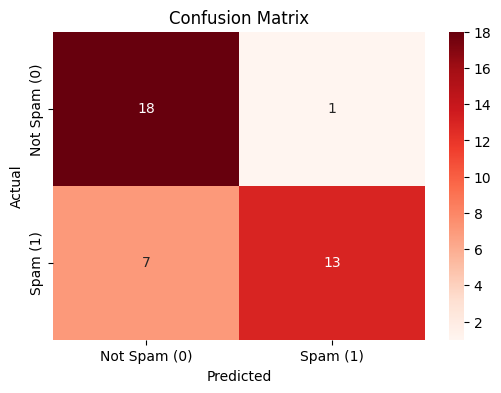

In [444]:
model_evaluation(y_test2, y_pred)

In [449]:
results = pd.DataFrame({
      "Message": X_test["Message"].values,
    "Actual": y_test2.values,
    "Predicted": y_pred,
    "Spam_Prob": y_proba
})

results.head(20)


,Message,Actual,Predicted,Spam_Prob
0,"Hey👋 ,i’ve got 4 billie eilish tickets for thu...",1,1,0.961294
1,"i baked cookies and they kinda slap, free to a...",0,1,0.603237
2,god bless the admin,0,0,0.385306
3,Lol why did the professor give us 3 assignment...,0,0,0.389768
4,I want to give out my playstation 5 and its du...,1,0,0.336181
5,IM Coed Volleyball FINALS is tonight at 6:45pm...,0,0,0.079688
6,i made extra banana bread and don’t trust myse...,0,0,0.311087
7,"Hey, can you help me with something? Look at t...",1,0,0.098405
8,❗Important news! 🎉 You are one of the winner i...,1,0,0.426186
9,I just want to apologize first because I was a...,1,1,0.572254


# ROC - AUC of both Models


In [446]:
from sklearn.metrics import roc_curve, auc

# Model 1
fpr1, tpr1, _ = roc_curve(y_test1, prob_baselr)
auc1 = auc(fpr1, tpr1)

# Model 2
fpr2, tpr2, _ = roc_curve(y_test2, y_proba)
auc2 = auc(fpr2, tpr2)


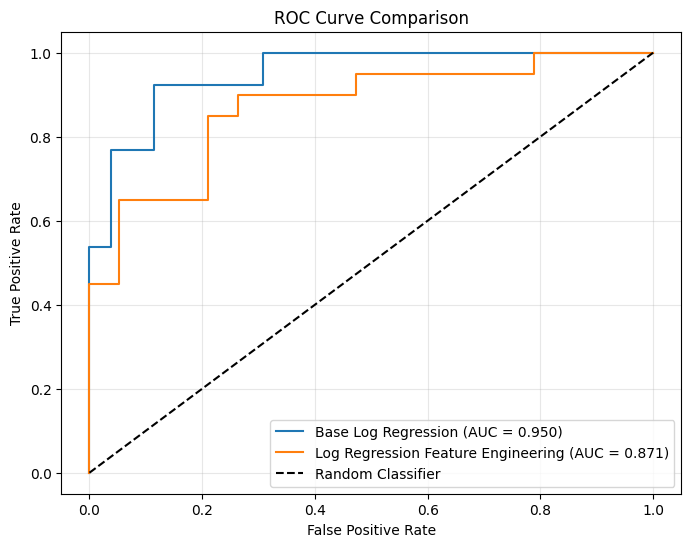

In [447]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.plot(fpr1, tpr1, label=f"Base Log Regression (AUC = {auc1:.3f})")

# Model 2
plt.plot(fpr2, tpr2, label=f"Log Regression Feature Engineering (AUC = {auc2:.3f})")

# Random chance line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")

plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# Conclusion
### Overal, base logistic regression with just the message vector as input did better


# Export Model and Vectorizer
### Save the trained model and vectorizer for use in main.py

In [ ]:
import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the base logistic regression model and vectorizer
joblib.dump(lr_base, '../models/logistic_regression_model.pkl')
joblib.dump(vectorizer, '../models/logistic_regression_vectorizer.pkl')

print('Model saved to: ../models/logistic_regression_model.pkl')
print('Vectorizer saved to: ../models/logistic_regression_vectorizer.pkl')